# Long-term forecasting of volatility
## This notebook is about forecasting of volatility using GARCH models. First, we will try to simulate a GARCH time series, than fit a GARCH model to it and forecast future volatility. Then we will try to compare the results with a SVR model. 
## After that we will apply both model to the real market data.

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import time
import math
from sklearn.exceptions import DataConversionWarning
from sklearn import svm
from scipy import stats
import random
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error 
import warnings 
warnings.filterwarnings('ignore')
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
# function for simulations of garch(1,1) process 
def simulate_GARCH(N, omega, alpha, beta=0):
    
    a0 = omega
    a1 = alpha
    b1 = beta

    n = N
    w = np.random.normal(size=n)
    eps = np.zeros_like(w)
    sigsq = np.zeros_like(w)

    for i in range(1, n):
        sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
        eps[i] = w[i] * np.sqrt(sigsq[i])
    
    return eps, np.sqrt(sigsq)

In [3]:
# simulations of garch(2,2)
def simulate_GARCH_mod(n, omega, alpha1, alpha2, beta1=0, beta2=0):
    
    # Initialize our values
    sigma1 = 0.1
    X = np.ndarray(n)
    sigma = np.ndarray(n)
    sigma[0], sigma[1] = sigma1, sigma1
    X[0], X[1] = sigma1, sigma1
    for t in range(2, n):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(omega+beta1*sigma[t-1]**2+beta2*sigma[t-2]**2+alpha1*X[t-1]**2+alpha2*X[t-2]**2)
        
    X[n - 1] = sigma[n - 1] * np.random.normal(0, 1)    
    
    return X, sigma

## In the case of GARCH(1,1) for prediction for horizon h we use formula :
## $E_{t-1} [\sigma^2_{t+h}] = \omega* \sum_{i=0}^{h-1}(\alpha+\beta)^i + (\alpha+\beta)^h*\sigma_t^2 = \omega*\frac{1-(\alpha+\beta)^{h-1}}{1-\alpha - \beta} + (\alpha+\beta)^h*\sigma_t^2$
## In the case of GARCH(2,2) for prediction for horizon h we use formula :
## $E_{t-1} [\sigma^2_{t+h}] = \omega* \sum_{i=0}^{h-1}(\alpha_1+\beta_1)^i + (\alpha_1+\beta_1)^h*\sigma_t^2+  \omega* \sum_{i=0}^{h-2}(\alpha_2+\beta_2)^i + (\alpha_2+\beta_2)^{h-1}*\sigma_t^2  = \omega*\frac{1-(\alpha_1+\beta_1)^{h-1}}{1-\alpha_1 - \beta_1} + (\alpha_1+\beta_1)^h*\sigma_t^2+\omega*\frac{1-(\alpha_2+\beta_2)^{h-2}}{1-\alpha_2 - \beta_2} + (\alpha_2+\beta_2)^{h-1}*\sigma_t^2$

# SVR

In [4]:
l = int(5000-15)*0.8
l

3988.0

### The reference of this code is $\href{https://github.com/danielgy/Time-Series-Forecasting}{source}$

In [5]:
def predict_ts(sigma, h):
    # predict square of returns
    l = int(len(sigma)-15)*0.8
    sigma_train, sigma_test =  np.power(sigma[:3988],2), np.power(sigma[3988:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:3988-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:997-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    
   # param_grid = {'C': [0.1, 1], 'gamma': [1,'auto', 'scale', 10],'kernel': ['rbf','poly', 'sigmoid']}
    svr = SVR(C=1, gamma=1, kernel='sigmoid')
    #GridSearchCV(SVR(), param_grid, refit=True, verbose=1)
    svr.fit(X_train,y_train)
    #svr = grid.best_estimator_

    svr.fit(X_train,y_train)
    p = svr.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    return error

In [27]:
def garch22(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:3988],ret[3988:], sigma[:3988],sigma[3988:]
    pred = []
    real = []
    k = len(ret_test)
    warnings.filterwarnings('ignore')
     # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=2, q=2).fit(disp='off')
    #read coefficients 
    omega,a1,b1,a2,b2 = (garch.params['omega'], garch.params['alpha[1]'],
                              garch.params['beta[1]'], garch.params['alpha[2]'], garch.params['beta[2]'])
    
    for i in range(h,k):

        #calculate sigma square
        pred_sigma2 =(omega*(1+ (1-np.power(a1+b1, h-1))/(1-a1-b1)) + np.power(a1+b1,h)* sigma_train[-h]**2+
                       omega*(1+ (1-np.power(a2+b2, h-2))/(1-a2-b2)) + np.power(a2+b2,h-1)* sigma_train[-h-1]**2)
        
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])

    mse_garch2 = mean_squared_error(pred, real)
    
    return mse_garch2

In [28]:
def garch11(ret, sigma, h):
    l = int(len(sigma)-15)*0.8
    ret_train, ret_test, sigma_train, sigma_test = ret[:3988],ret[3988:], sigma[:3988],sigma[3988:]

    pred = []
    real = []
    k = len(ret_test)
    # fit a built-in function to estimate coefficients 
    garch = arch_model(ret_train, p=1, q=1).fit(disp='off')
    #read coefficients 
    omega,a1,b1 = garch.params['omega'], garch.params['alpha[1]'], garch.params['beta[1]']
    
    
    for i in range(h,k):

        #calculate sigma square
        pred_sigma2 = omega*(1+ (1-np.power(a1+b1, h-1))/(1-a1-b1)) + np.power(a1+b1,h)* sigma_train[-h]**2
        
        pred.append(pred_sigma2)
        real.append(sigma_test[0]**2)
        #print(pred_sigma2, sigma_test[0]**2)
        ret_train = np.append(ret_train, ret_test[0])
        ret_test = np.delete(ret_test, [0])
        sigma_train = np.append(sigma_train, sigma_test[0])
        sigma_test = np.delete(sigma_test, [0])



    mse_garch1 = mean_squared_error(pred,real)
    return mse_garch1

In [29]:
def rf_predict(sigma, h):
    warnings.filterwarnings('ignore')
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    sigma_train, sigma_test =  np.power(sigma[:3988],2), np.power(sigma[3988:],2)
    # reshape to an appropriate forma
    sigma_train = sigma_train.reshape(-1, 1)
    sigma_test = sigma_test.reshape(-1,1)
    
    # scaling to ensure the data is projected in the interval 0,1.
    scaler = MinMaxScaler()
    sigma_train = scaler.fit_transform(sigma_train)
    X_train = sigma_train[:3988-h]
    y_train= sigma_train[h:]
    X_test = sigma_test[:997-h]
    y_test = sigma_test[h:]
    
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomForestRegressor(bootstrap=False, max_depth=10, max_features='auto',
                      min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)
    #RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                  # n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train.ravel())
    
    p = rf_random.predict(X_test)
    predictions = scaler.inverse_transform(np.array(p).reshape(-1, 1))
    error = mean_squared_error(y_test, predictions)
    
    return error

# Сompare models on 1 simulated series of GARCH(1,1)

In [35]:
err_1 = []
err_2 = []
err_svr = []
err_rf = []
ret,sigma = simulate_GARCH(N=5000, omega=0.01, alpha=0.15, beta=0.65)
ret = ret[15:]
sigma = sigma[15:]

for h in range(2,25):
    err_1.append(garch11(ret, sigma, h))
    err_2.append(garch22(ret, sigma, h))
    err_svr.append(predict_ts(sigma,h))
    err_rf.append(rf_predict(sigma, h))

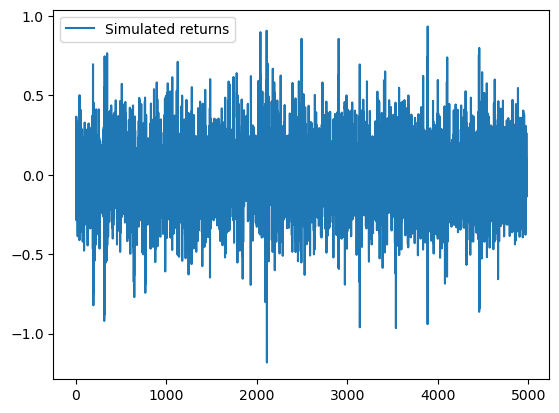

In [36]:
plt.plot(ret[0:], label='Simulated returns')
plt.legend()
plt.show()

In [37]:
len(err_1)

23

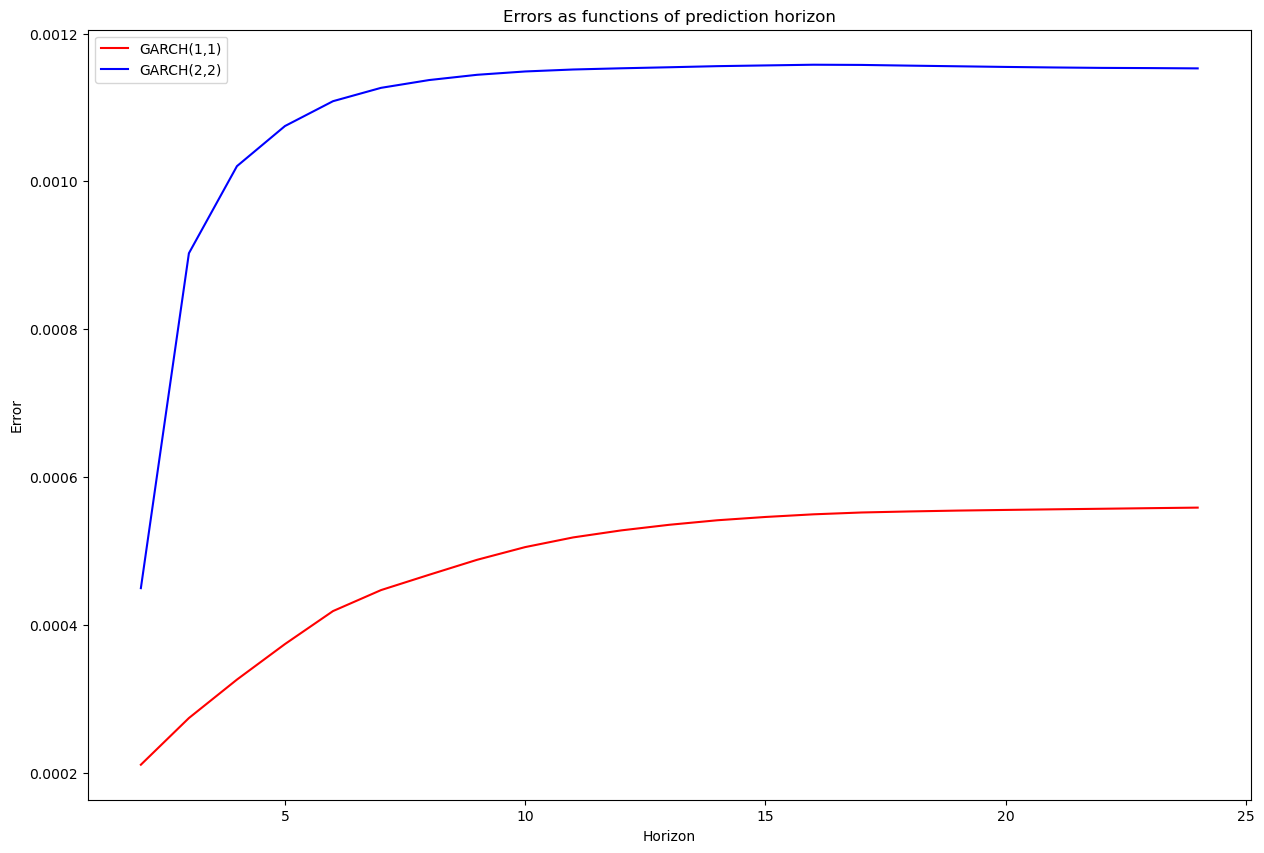

In [38]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),err_2,color='blue', label="GARCH(2,2)") 
plt.plot(range(2,25),err_rf,color='yellow', label="RF")
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

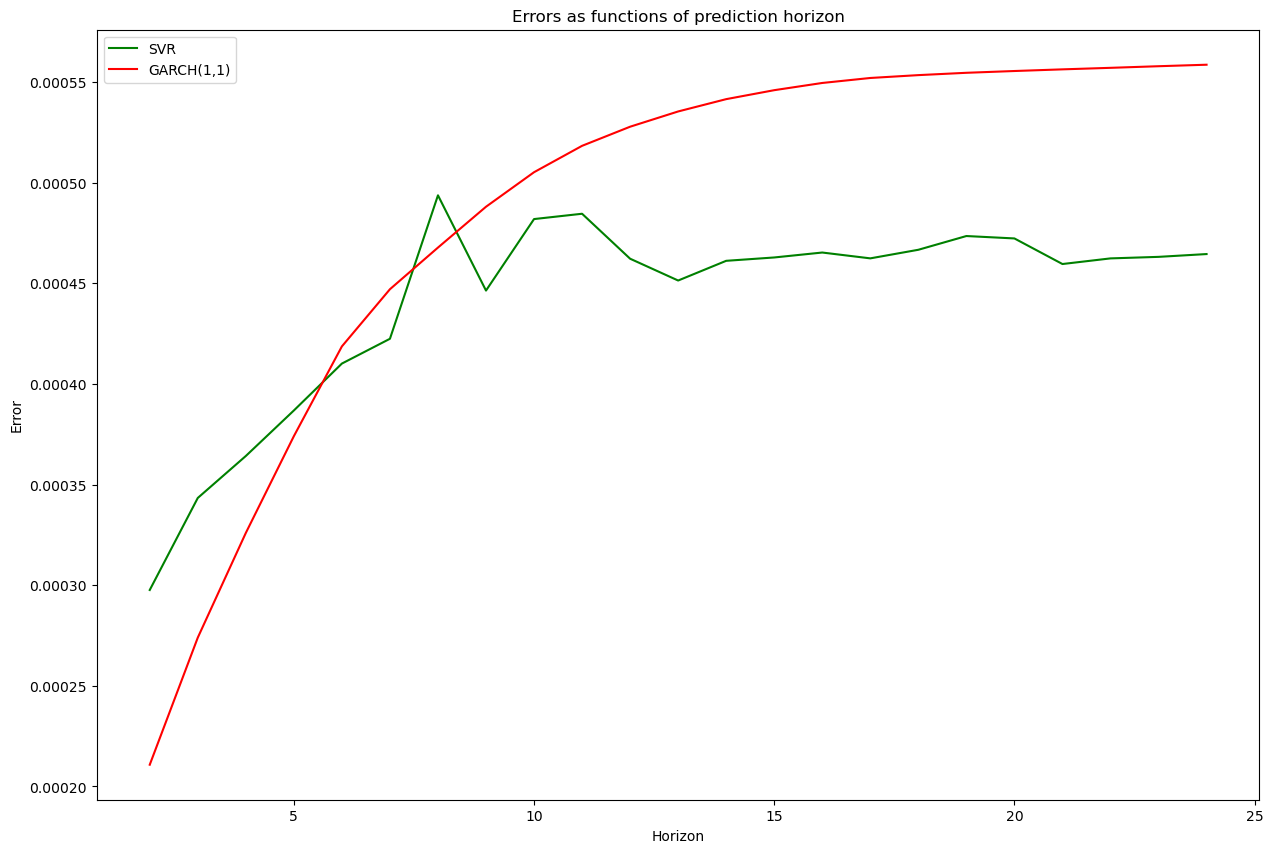

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),err_svr,color='green', label='SVR') 
plt.plot(range(2,25),err_1,color='red', label="GARCH(1,1)") 
plt.title('Errors as functions of prediction horizon') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## Мы можем видеть, что некорректно специфицированный GARCH(2,2) проявляет себя хуже всего, в то время как GARCH(1,1) показывает наименьшую ошибку почти на всех горизонтах прогнозирования. Метод машинного обучения SVR же ведет себя почти также хорошо, как GARCH(1,1)

# Сompare models on 10 simulated series of GARCH(1,1)

In [40]:
err_11 = []
err_21 = []
err_svr1 = []
err_rf1 = []
    
err_1h = []
err_2h = []
err_svrh = []
err_rfh = []

error_count = 0
for i in range(100):
    try:
        ret,sigma = simulate_GARCH(N=5000, omega=0.01, alpha=0.15, beta=0.65)
        ret = ret[15:]
        sigma = sigma[15:]
        for h in range(2,25):
            err_1h.append(garch11(ret, sigma, h))
            err_2h.append(garch22(ret, sigma, h))
            err_svrh.append(predict_ts(sigma,h))
            err_rfh.append(rf_predict(sigma, h))

        err_11.append(err_1h)
        err_21.append(err_2h)
        err_svr1.append(err_svrh)
        err_rf1.append(err_rfh)

        err_1h = []
        err_2h = []
        err_svrh = []
        err_rfh = []
    
    except ValueError as e:
        error_count+=1
        pass

In [41]:
k = 100-error_count

In [42]:
len(err_11)

100

In [43]:
garch11_avr = np.zeros(23)
garch22_avr = np.zeros(23)
svr_avr = np.zeros(23)
rf_avr = np.zeros(23)
bug_count = 0
for i in range(k):
    if  (np.array(err_11[i]).shape[0]) <= 23: 
        garch11_avr = np.add(garch11_avr, np.array(err_11[i]))
        garch22_avr = np.add(garch22_avr, err_21[i]) 
        svr_avr = np.add(svr_avr, err_svr1[i])
        rf_avr = np.add(rf_avr, err_rf1[i])
    else:
        bug_count+=1
    
    
garch11_avr = np.divide(garch11_avr,100-error_count-bug_count)
garch22_avr = np.divide(garch22_avr,100-error_count-bug_count)
svr_avr = np.divide(svr_avr,100-error_count-bug_count)
rf_avr = np.divide(rf_avr,100-error_count-bug_count)

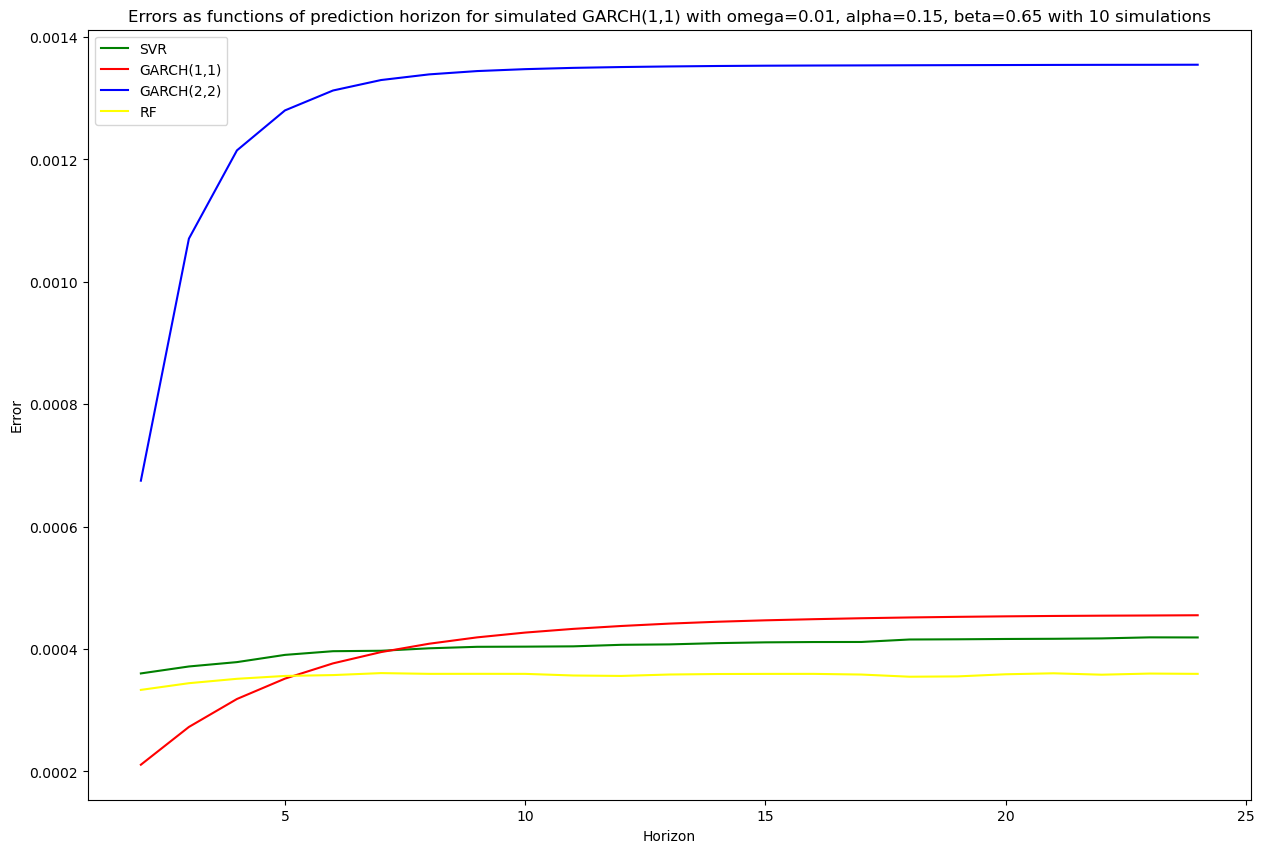

In [44]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),garch22_avr,color='blue', label="GARCH(2,2)") 
plt.plot(range(2,25),rf_avr,color='yellow', label="RF")
plt.title('Errors as functions of prediction horizon for simulated GARCH(1,1) with omega=0.01, alpha=0.15, beta=0.65 with 10 simulations') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## 

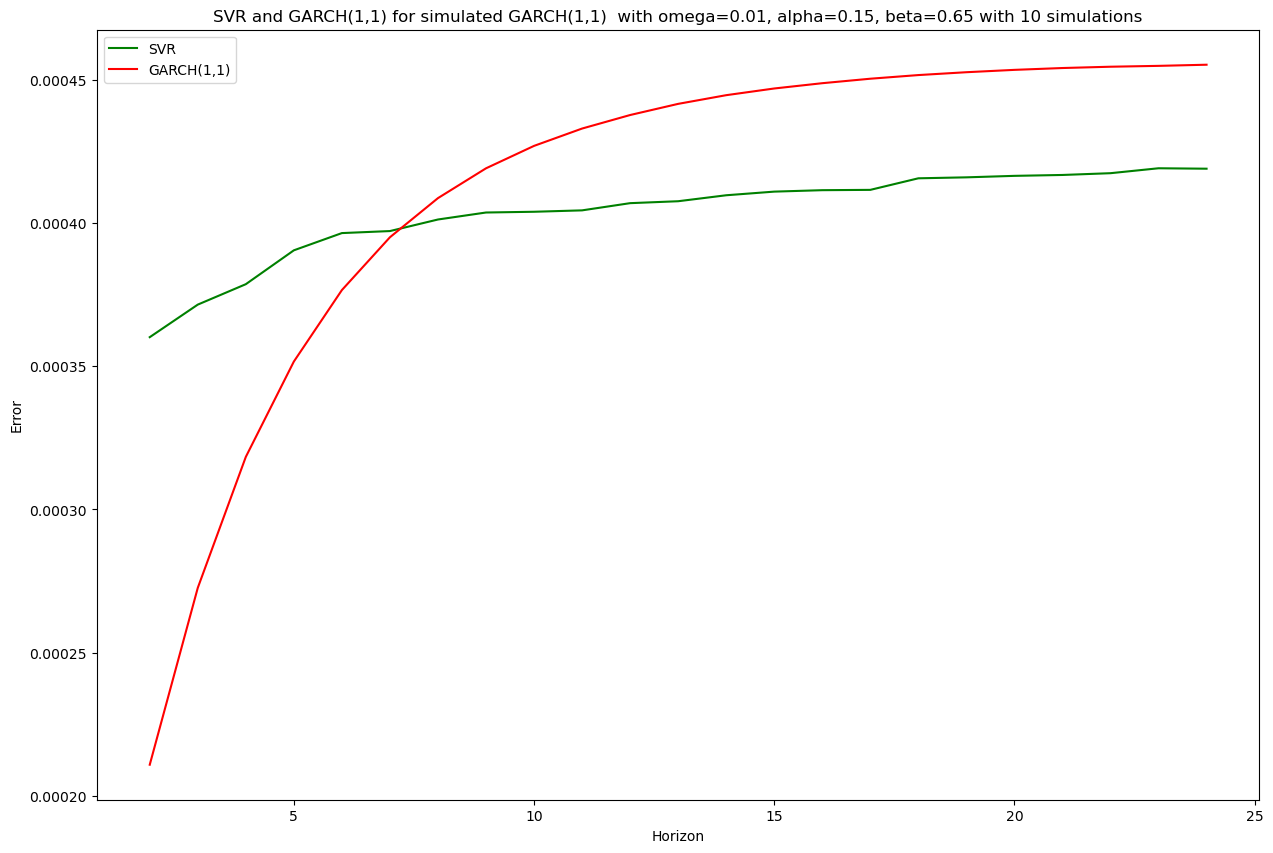

In [45]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.title('SVR and GARCH(1,1) for simulated GARCH(1,1)  with omega=0.01, alpha=0.15, beta=0.65 with 10 simulations') 
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

## It is surprising that the error is almost constant function of the prrediction horison for all models, because it would be logical if it had been increasing. In other aspects results are logical, the correctly specified GARCH is the best and misspesified is the worst.

# Сompare models on 10 simulated series of GARCH(2,2)

In [46]:
err_11 = []
err_21 = []
err_svr1 = []
err_rf1 = []
    
err_1h = []
err_2h = []
err_svrh = []
err_rfh = []

error_count = 0
for i in range(100):
    try:
        ret,sigma = simulate_GARCH_mod(n=5000, omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2)
        ret = ret[15:]
        sigma = sigma[15:]
        for h in range(2,25):
            err_1h.append(garch11(ret, sigma, h))
            err_2h.append(garch22(ret, sigma, h))
            err_svrh.append(predict_ts(sigma,h))
            err_rfh.append(rf_predict(sigma, h))

        err_11.append(err_1h)
        err_21.append(err_2h)
        err_svr1.append(err_svrh)
        err_rf1.append(err_rfh)

        err_1h = []
        err_2h = []
        err_svrh = []
        err_rfh = []
    
    except ValueError as e:
        error_count+=1
        pass

In [47]:
len(err_11)

100

In [48]:
garch11_avr = np.zeros(23)
garch22_avr = np.zeros(23)
svr_avr = np.zeros(23)
rf_avr = np.zeros(23)
bug_count = 0
for i in range(k):
    if  (np.array(err_11[i]).shape[0]) <= 23: 
        garch11_avr = np.add(garch11_avr, np.array(err_11[i]))
        garch22_avr = np.add(garch22_avr, err_21[i]) 
        svr_avr = np.add(svr_avr, err_svr1[i])
        rf_avr = np.add(rf_avr, err_rf1[i])
    else:
        bug_count+=1
    
    
garch11_avr = np.divide(garch11_avr,100-error_count-bug_count)
garch22_avr = np.divide(garch22_avr,100-error_count-bug_count)
svr_avr = np.divide(svr_avr,100-error_count-bug_count)
rf_avr = np.divide(rf_avr,100-error_count-bug_count)

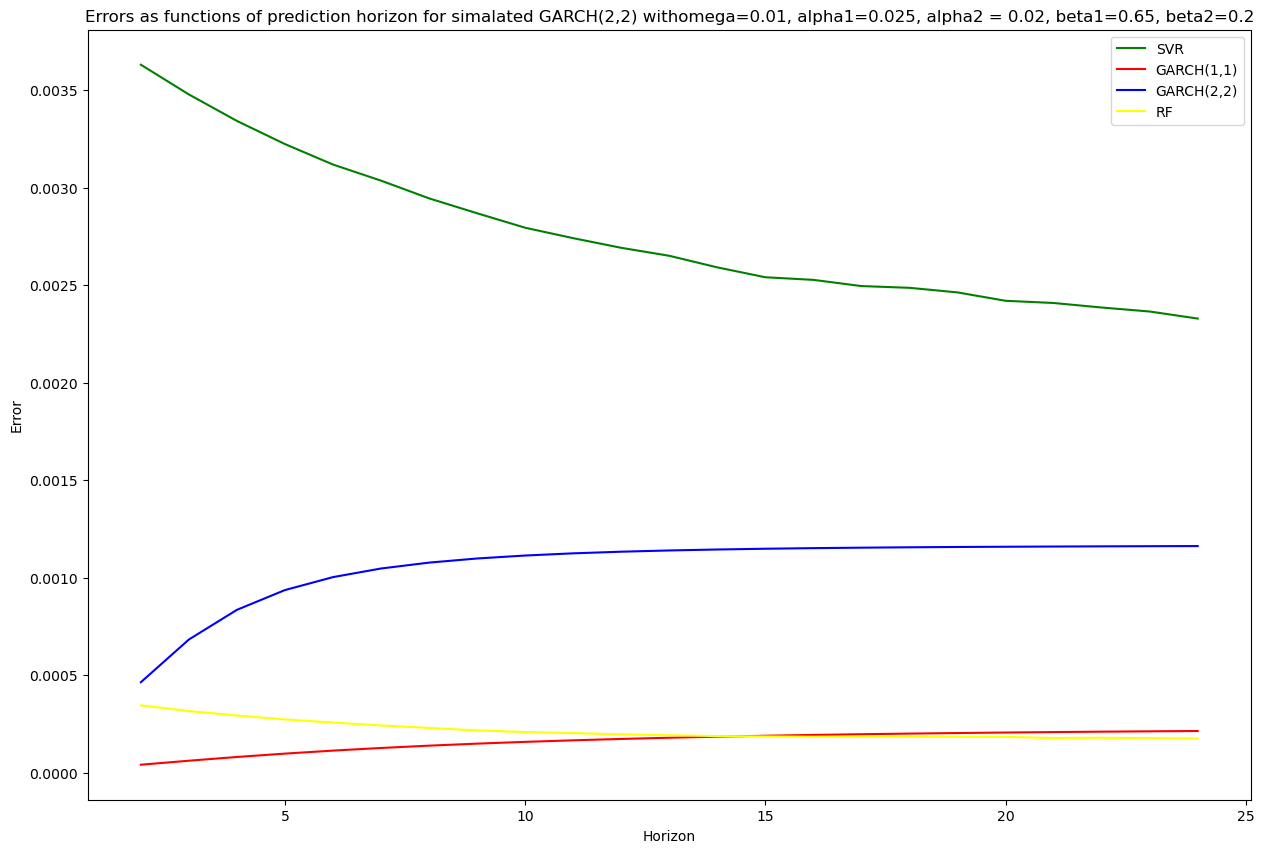

In [49]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),svr_avr,color='green', label='SVR') 
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),garch22_avr,color='blue', label="GARCH(2,2)") 
plt.plot(range(2,25),rf_avr,color='yellow', label="RF")

plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) withomega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

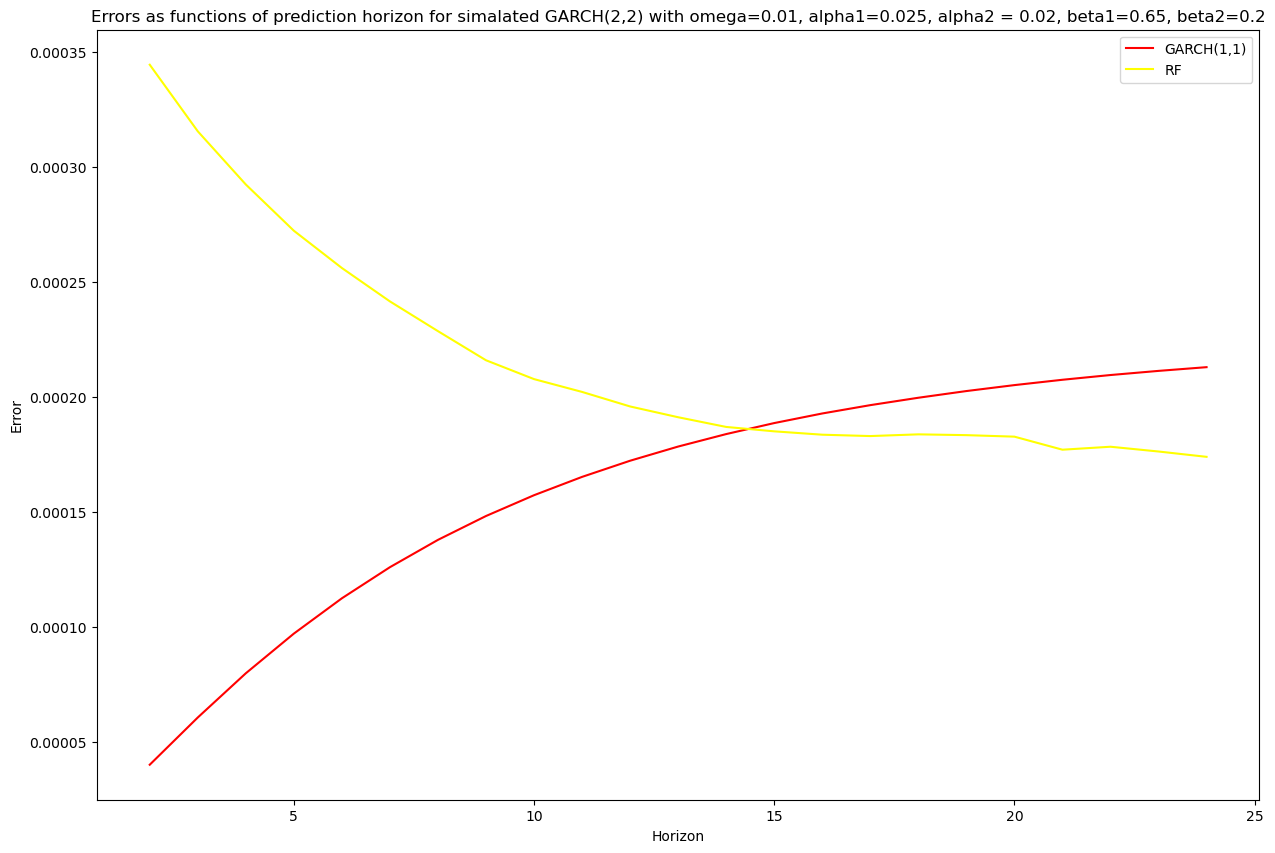

In [52]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.plot(range(2,25),rf_avr,color='yellow', label="RF")
plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) with omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()

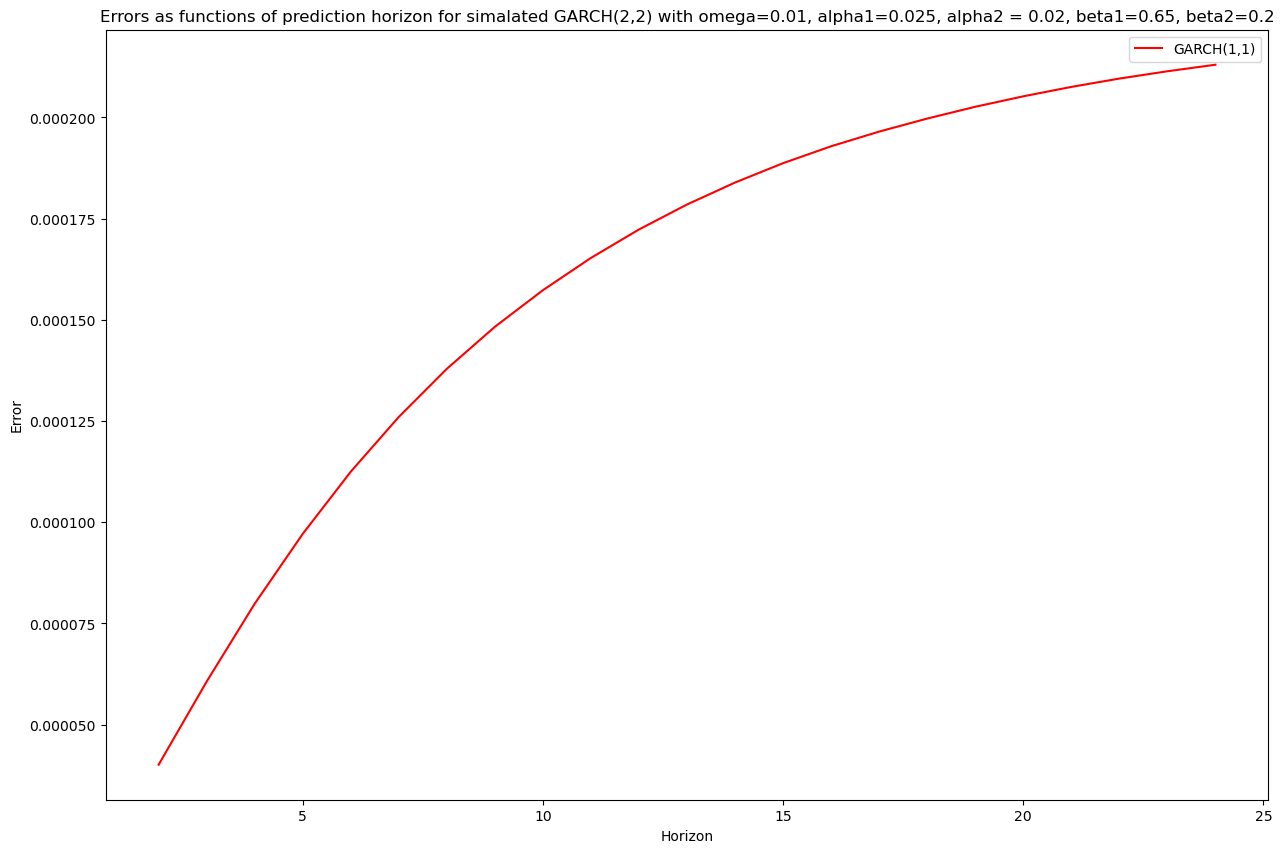

In [51]:
plt.figure(figsize=(15, 10))
plt.plot(range(2,25),garch11_avr,color='red', label="GARCH(1,1)") 
plt.title('Errors as functions of prediction horizon for simalated GARCH(2,2) with omega=0.01, alpha1=0.025, alpha2 = 0.02, beta1=0.65, beta2=0.2')
plt.ylabel('Error') 
plt.xlabel('Horizon') 
plt.legend()
plt.show()